In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import pathlib


Bat_Computer = True
if(Bat_Computer):
    projects_path = '/home/ibrahim/Projects/Self_Maneuvering_UGV/'

else:
    projects_path = '/home/ibrahim/Projects/Self_Maneuvering_UGV/'


images_path = '/home/ibrahim/Projects/Datasets/Ch2_001/center/'
csv_path    = '/home/ibrahim/Projects/Datasets/Ch2_001/final_example.csv'

In [2]:
csv_file = pd.read_csv(csv_path)
csv_file['frame_id'] = csv_file['frame_id'].astype(str)
print(csv_file.head(3))

image_names =  images_path +  csv_file['frame_id'] + '.jpg'
steering_angles = csv_file['steering_angle']
print(image_names[0])
print(steering_angles[0])


              frame_id  steering_angle
0  1479425441182877835       -0.373665
1  1479425441232704425       -0.065396
2  1479425441282730750       -0.160735
/home/ibrahim/Projects/Datasets/Ch2_001/center/1479425441182877835.jpg
-0.37366510611027504


In [3]:
steering_angles.shape

(5614,)

Image shape:  (480, 640, 3)
Label:  -0.37366510611027504


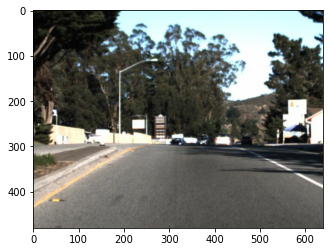

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((image_names,steering_angles))

def _load_images(filename, target):

    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, target


dataset = dataset.map(_load_images)

for image, label in dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image)
